# Backtracking Inpainting


Consider an image $x^0$ and a masking operator $M$. Let $y=Mx^0$ be the damaged version of $x^0$. The objective is to get an approximation of $x^0$ knowing $y$ and $M$. This problem can be written as follows:
$$
\min\limits_{x}F(x)=\frac{1}{2}\|Mx-y\|^2+\lambda\|Tx\|_1,
$$
where $T$ is an orthogonal transformation ensuring that $Tx^0$ is sparse. In this example, $x^0$ is piecewise smooth so we chose $T$ as an orthogonal wavelet transform. 

### Importing libraries, generating data and operators

In [7]:
# Importing libraries
import numpy as np
import scipy as scp
import pylab as pyl
import pywt
import matplotlib.pyplot as plt
from PIL import Image
import time

In [8]:
#Importing additional packages: algorithms.py contains the algorithms to apply and visualizer.py is useful to plot loss functions.
import os.path
if not os.path.isfile('./visualizer.py'):
    !wget https://github.com/HippolyteLBRRR/Composite_optimization/raw/main/visualizer.py
if not os.path.isfile('./algorithms.py'):
    !wget https://github.com/HippolyteLBRRR/Composite_optimization/raw/main/algorithms.py
from algorithms import *
from visualizer import *

In [3]:
#Definition of the operators

def SoftThreshold_Wvt(I,wave,Seuil):
    L=pywt.dwt_max_level(len(I),pywt.Wavelet(wave).dec_len)
    wavelet_coeffs= pywt.wavedecn(I, wave, mode='per', level=L)
    arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(wavelet_coeffs)
    temp=pywt.threshold(arr,Seuil,mode='soft')
    test=pywt.unravel_coeffs(temp, coeff_slices, coeff_shapes, output_format='wavedecn')
    Irec=pywt.waverecn(test, wave,mode='per')
    return Irec
def Normel1Ondelettes(I,wave):
    L=pywt.dwt_max_level(len(I),pywt.Wavelet(wave).dec_len)
    wavelet_coeffs= pywt.wavedecn(I, wave, mode='per', level=L)
    arr, coeff_slices, coeff_shapes = pywt.ravel_coeffs(wavelet_coeffs)
    norml1=sum(np.abs(arr))
    return norml1
def operators_Inpainting(im,M,lam,wave):
    F=lambda x:0.5*np.linalg.norm(M*x-im)**2+lam*Normel1Ondelettes(x,wave)
    f=lambda x:0.5*np.linalg.norm(M*x-im)**2
    h=lambda x:lam*Normel1Ondelettes(x,wave)
    Df=lambda x:M*(x-im)
    proxh=lambda x,s:SoftThreshold_Wvt(x,wave,s*lam)
    return F,f,h,Df,proxh

In [4]:
def upsize(im):
    n,m=np.shape(im)
    N=np.maximum(n,m)
    k=int(np.ceil(np.log(N)/np.log(2)))
    temp=np.zeros((2**k,2**k))
    temp[:n,:m]=im
    return temp

Text(0.5, 1.0, 'Damaged image')

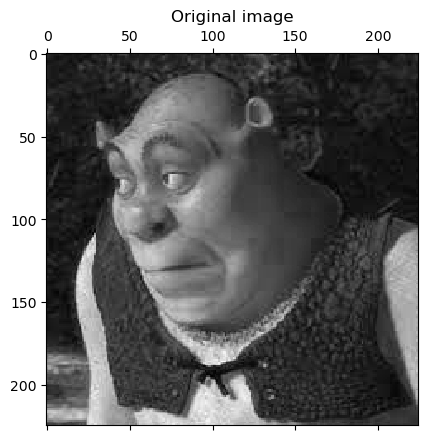

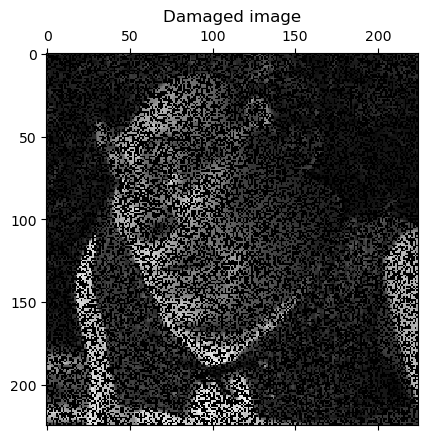

In [5]:
# Generating data
im=np.array(Image.open("./shrek.jpeg")).astype(float)[:,:,0] #other images can be considered
np.random.seed(seed=1)
n1,n2=np.shape(im)
r=np.random.rand(n1,n2)
prop = 0.5 #Proportion of damaged data
M=(r<prop)
M = M*1.0
im_masq=im*M
wave="db4" # Wavelet basis considered
lam=2 # Regularization parameter
big_im_masq=upsize(im_masq)
big_M=upsize(M)
F,f,h,Df,proxh=operators_Inpainting(big_im_masq,big_M,lam,wave) 
exit_crit=lambda x,y:npl.norm(x-y) #critère d'arrêt -> norm of the composite gradient
sp=lambda x,y:np.dot(x.ravel(),y.ravel()) #scalar product considered
x0=big_im_masq
L=1
plt.matshow(im,cmap="gray")
plt.title("Original image")
plt.matshow(im_masq,cmap="gray")
plt.title("Damaged image")

In [6]:
Niter=6000 # Maximum number of iterations (backtracking iterations are not taken in account)
epsilon=1e-6 # Expected accuracy on the composite gradient

## Applying first-order methods to this problem

In [9]:
# Documentation for the algorithms:
# help(FISTA)
# help(FISTA_automatic_restart)
# help(FISTA_BT)
# help(Free_FISTA)

In [10]:
# FISTA
xFISTA,coutFISTA,ctimeFISTA=FISTA(x0,1/L,Niter,epsilon,Df,proxh,F=F,exit_crit=exit_crit,track_ctime=True)
Plot_FISTA=To_Plot(coutFISTA,"FISTA",ctimeFISTA) # To_Plot object -> visualization

In [11]:
# FISTA restart by ADLR
xAR1,coutAR1,ctimeAR1=FISTA_automatic_restart(x0,1/L,Niter,epsilon,Df,proxh,F,exit_crit=exit_crit,track_ctime=True)
Plot_AR1=To_Plot(coutAR1,"Automatic FISTA restart (ADLR)",ctimeAR1)

In [12]:
# FISTA with backtracking
L0=1
rho=0.85
delta=0.99
xBT,coutBT,ctimeBT,L_BT,ite_BT=FISTA_BT(x0, L0, rho, delta, Niter, epsilon, f, Df, proxh, h, exit_crit=exit_crit, sp=sp, out_L=True,out_ite=True, exit_norm=True,track_ctime=True)
Plot_BT=To_Plot(coutBT,"FISTA with backtracking",ctimeBT)

In [13]:
# Free FISTA
L0=1
rho=0.85
delta=0.99
xBTR,coutBTR1,ctimeBTR1,L_BTR1,ite_BTR1=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True,out_ite=True, exit_norm=True,track_ctime=True)
Plot_BTR1=To_Plot(coutBTR1,"Free-FISTA, rho=%f, delta=%f, L0=%i"%(rho,delta,L0),ctimeBTR1)

In [17]:
# Computing an accurate approximation of the solution for visualization
xmin = Free_FISTA(xBTR, L_BTR1[-1], rho, delta, 3000, 1e-9, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=False, out_L=False, out_ite=False, exit_norm=True,track_ctime=False)

/home_pers/labarrie/Bureau/benchmark_BT_restart/algorithms.py:961: RuntimeWarning: invalid value encountered in sqrt
  if (n<=C/np.sqrt(q)):


Text(0, 0.5, '$\\log(F(x_k)-\\hat F)$')

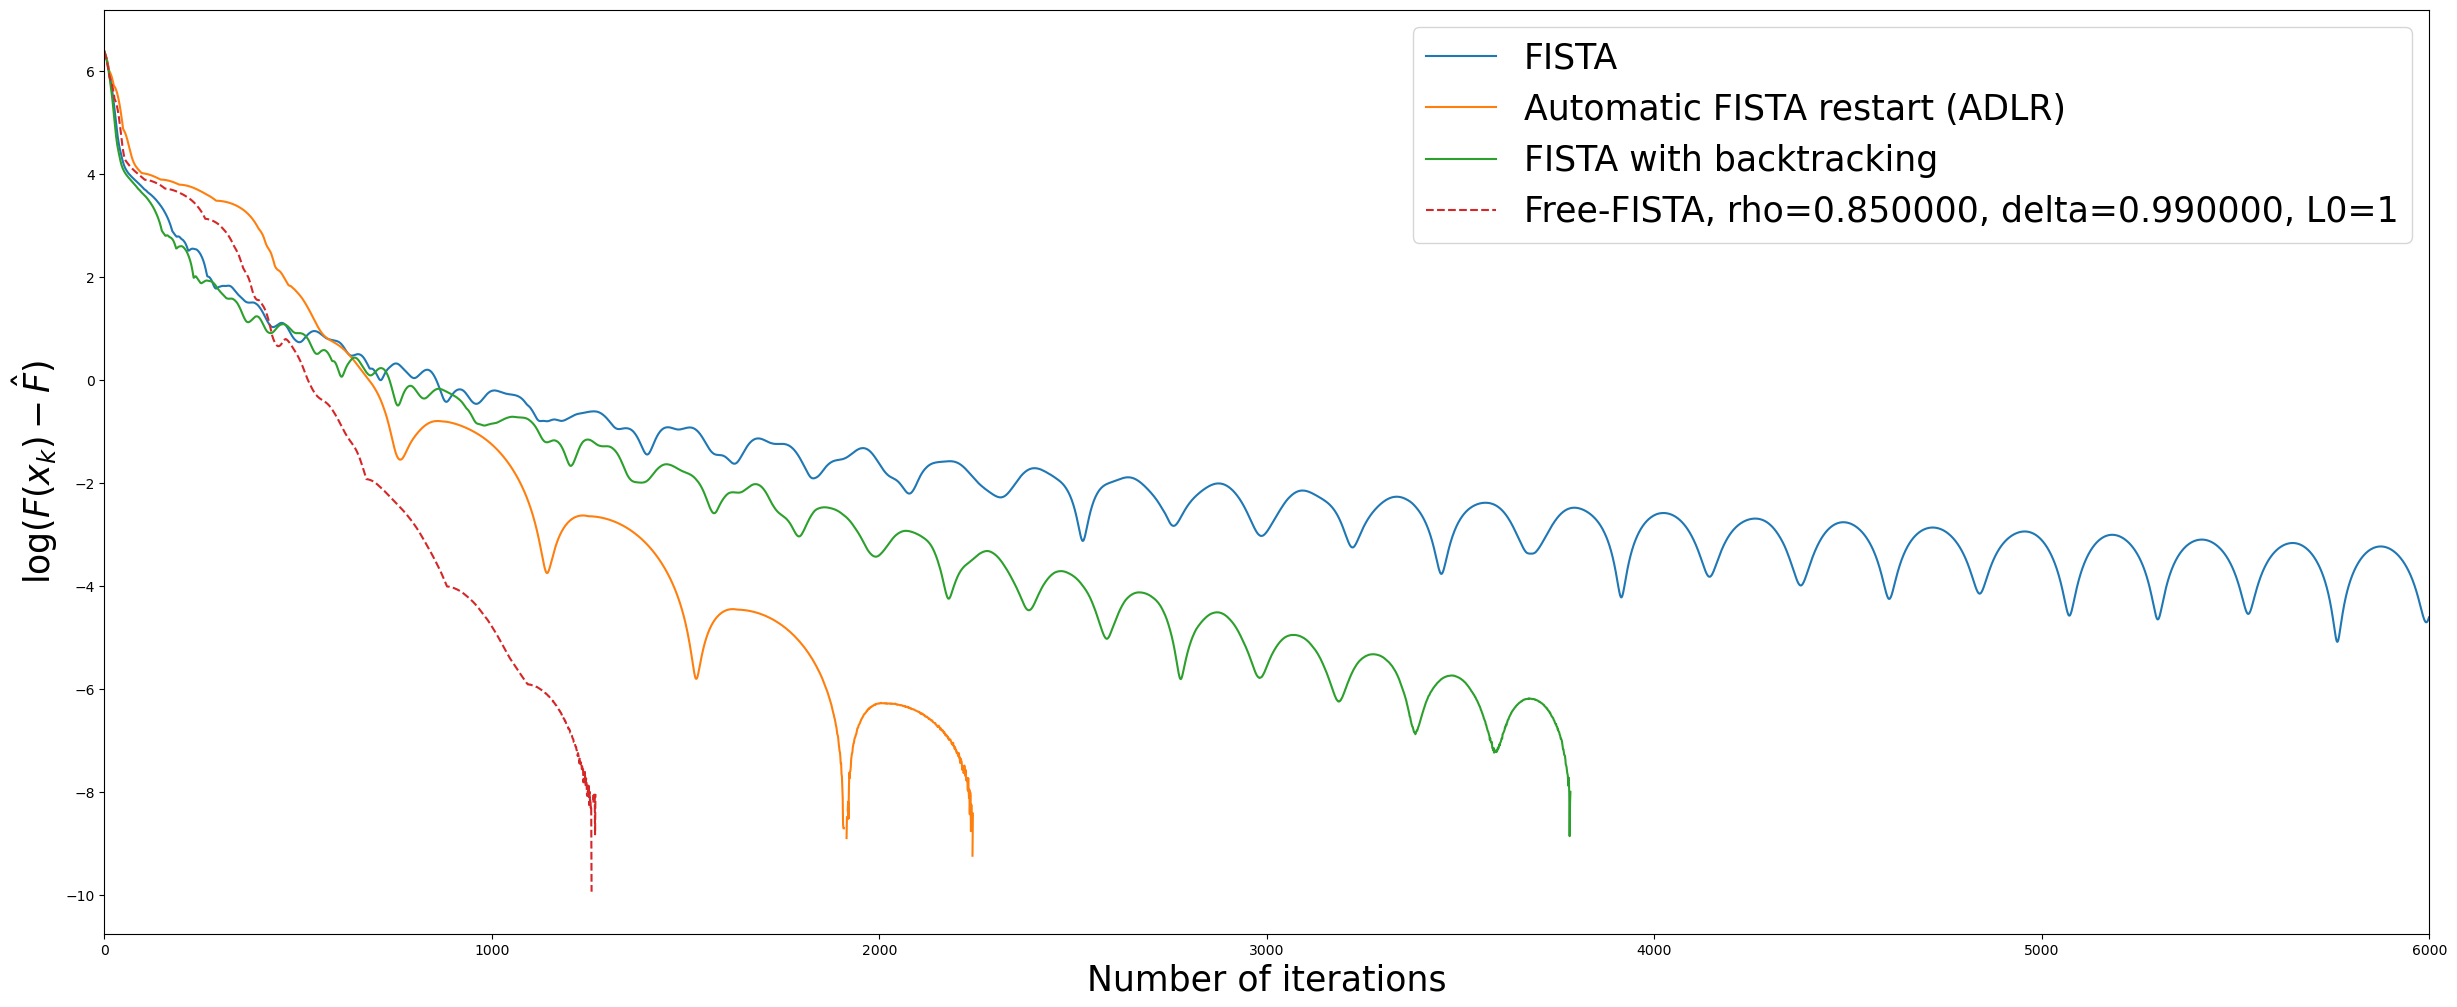

In [20]:
Plot([Plot_FISTA,Plot_AR1,Plot_BT,Plot_BTR1],coutmin=F(xmin),style=['-','-','-','--'],fontsize=25)
plt.xlabel("Number of iterations",fontsize=25)
plt.ylabel("$\log(F(x_k)-\hat F)$",fontsize=25)

Text(0, 0.5, '$\\log(F(x_k)-\\hat F)$')

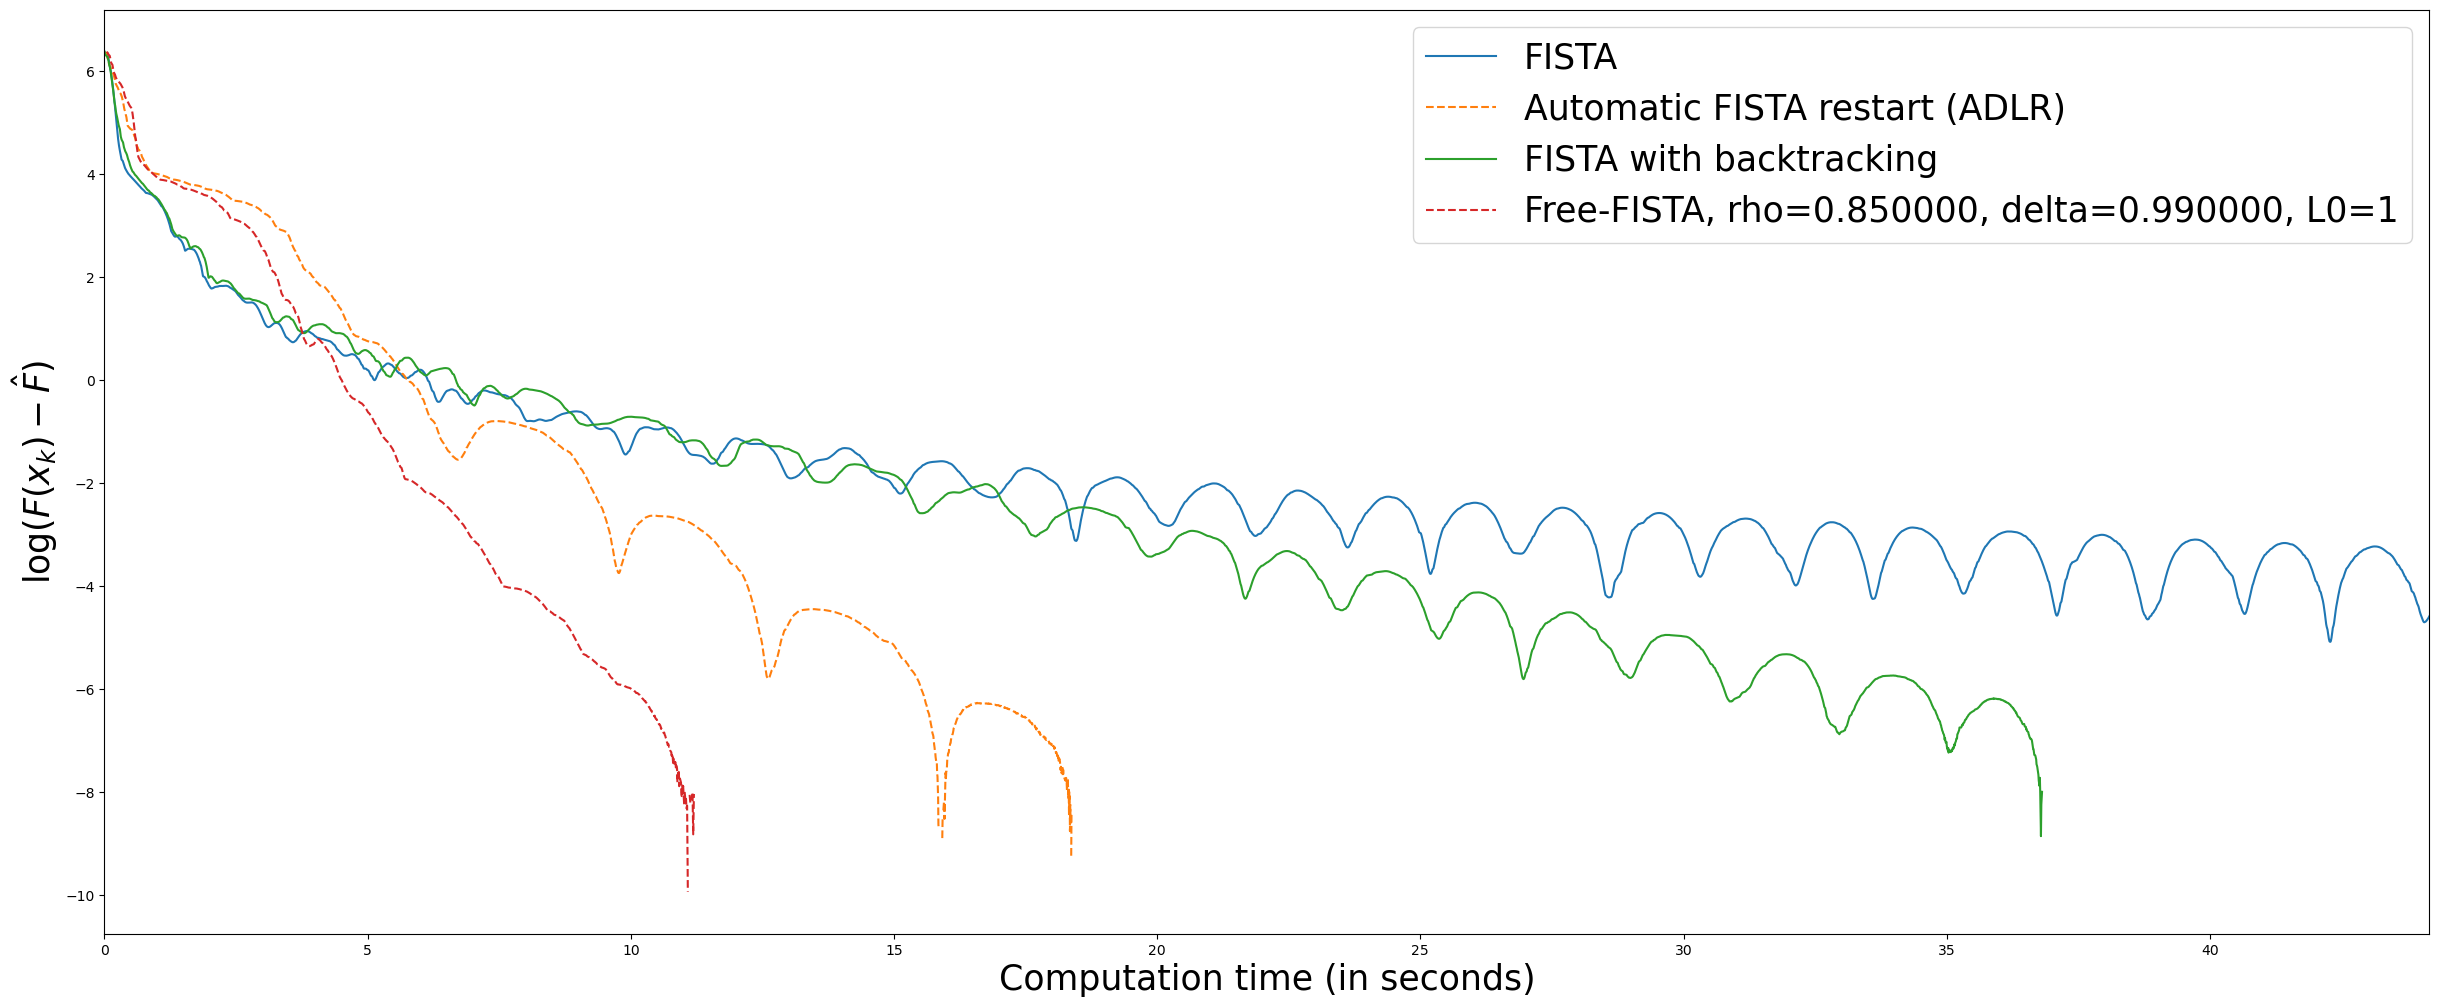

In [21]:
Plot([Plot_FISTA,Plot_AR1,Plot_BT,Plot_BTR1],coutmin=F(xmin),style=['-','--','-','--'],ite=False,fontsize=25)
plt.xlabel("Computation time (in seconds)",fontsize=25)
plt.ylabel("$\log(F(x_k)-\hat F)$",fontsize=25)

### Comparing different choices of parameters

In [23]:
L0=1
rho=0.85
delta=0.95
xBTR,coutBTR2,ctimeBTR2,L_BTR2,ite_BTR2=Free_FISTA(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=True, out_L=True,out_ite=True, exit_norm=True,track_ctime=True)
Plot_BTR2=To_Plot(coutBTR2,"Free-FISTA, rho=%f, delta=%f, L0=%i"%(rho,delta,L0),ctimeBTR2)

Text(0, 0.5, '$\\log(F(x_k)-\\hat F)$')

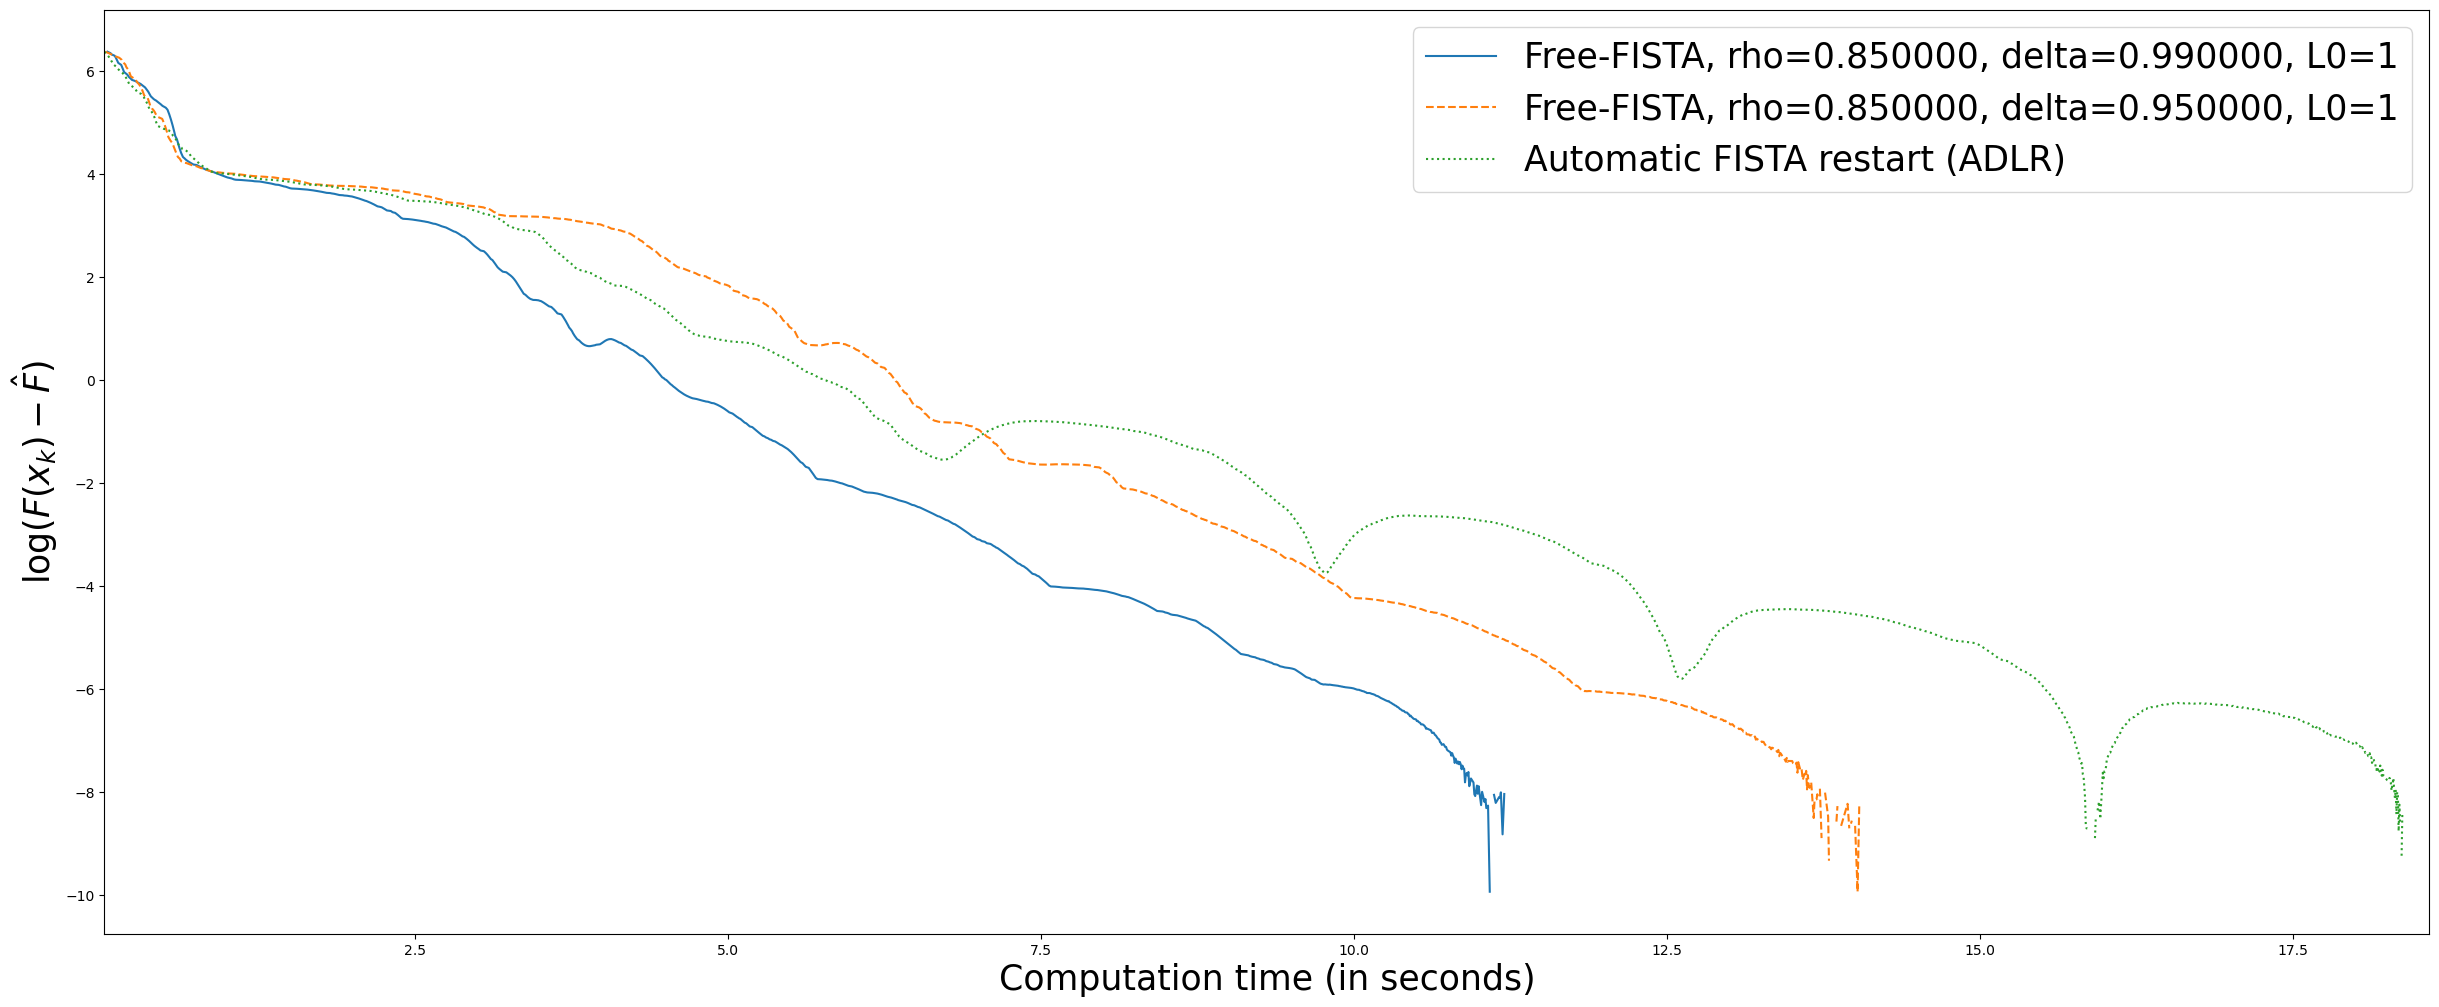

In [34]:
Plot([Plot_BTR1,Plot_BTR2,Plot_AR1],eps=1e-12,coutmin=F(xmin),style=['-','--',':'],ite=False,fontsize=25)
plt.xlabel("Computation time (in seconds)",fontsize=25)
plt.ylabel("$\log(F(x_k)-\hat F)$",fontsize=25)

### Comparison between the exact Lipschitz constant $L=1$ and the local estimation given by the method

Text(0.5, 0, 'Number of iterations')

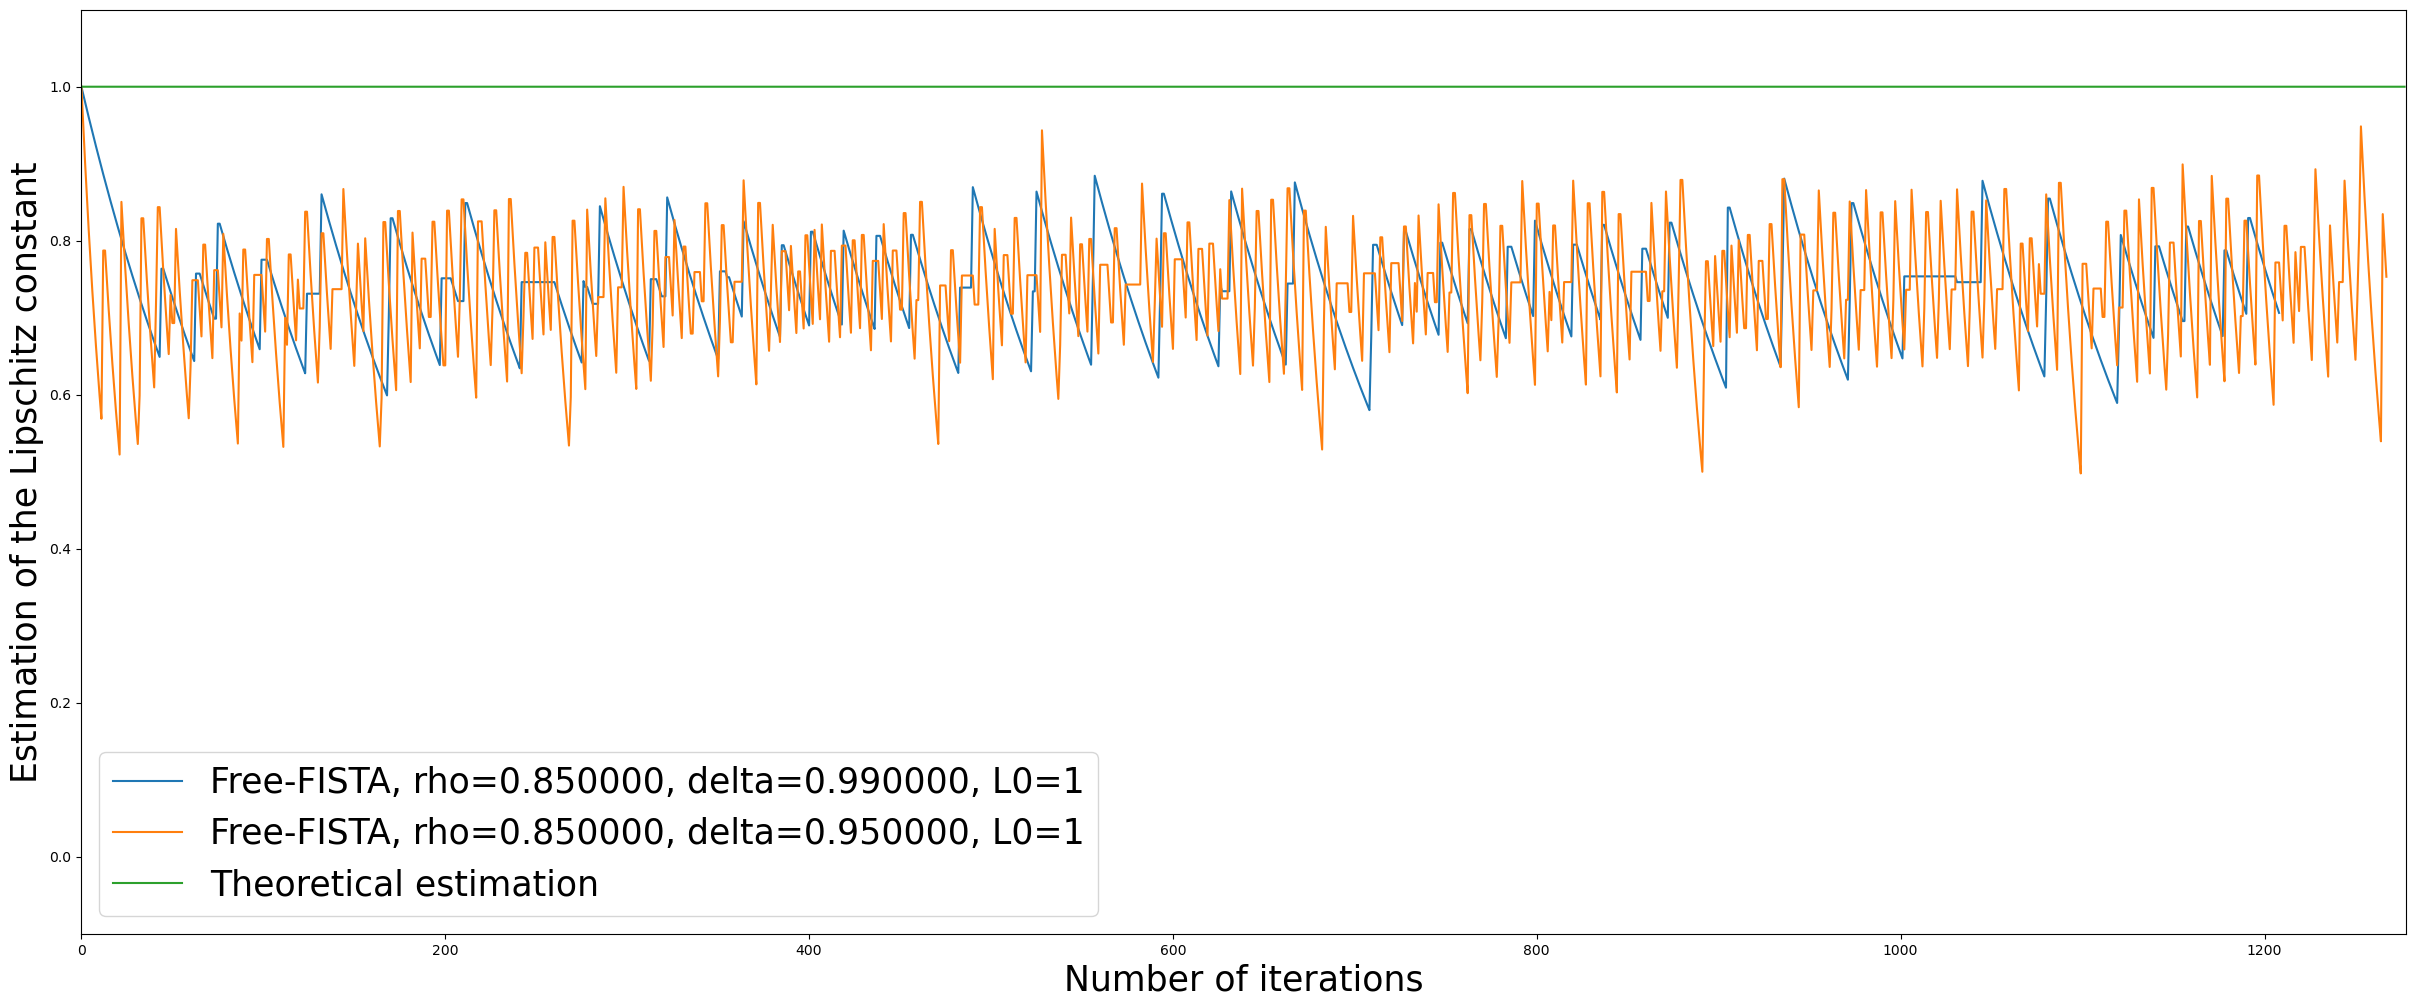

In [35]:
plt.plot(L_BTR1[:-60])
plt.plot(L_BTR2[:-60])
plt.plot(np.zeros_like(L_BTR2[:-50])+L)
plt.legend([Plot_BTR1.legend,Plot_BTR2.legend,"Theoretical estimation"],prop={'size': 25})
plt.xlim([0,len(L_BTR2)-50])
plt.ylim([-0.1,1.1])
plt.ylabel("Estimation of the Lipschitz constant",fontsize=25)
plt.xlabel("Number of iterations",fontsize=25)

(0.0, 1.2)

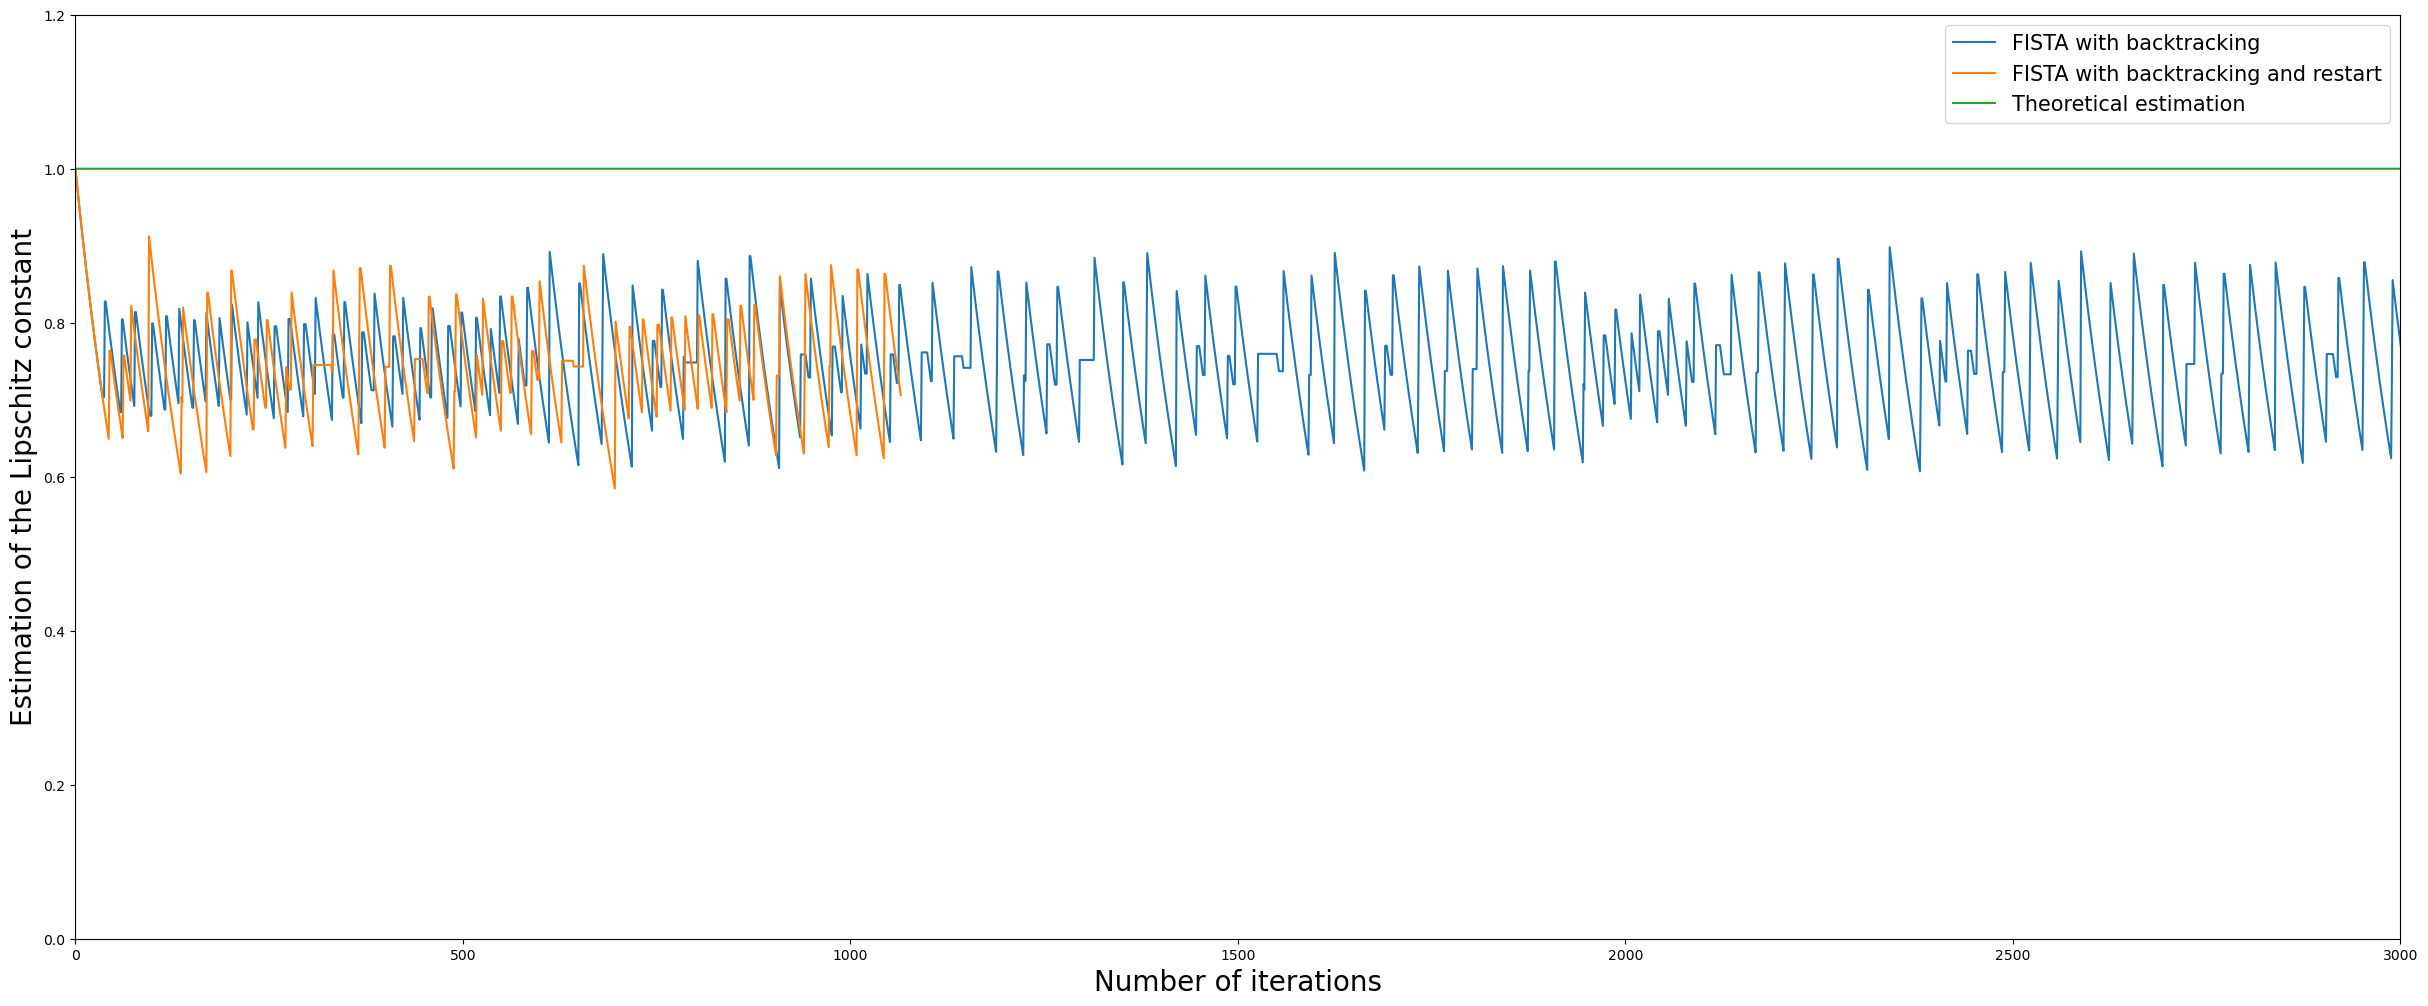

In [18]:
plt.plot(L_BT[:-50])
plt.plot(L_BTR1[:-50])
plt.plot(np.zeros_like(L_BT[:-50])+L)
plt.legend(["FISTA with backtracking","FISTA with backtracking and restart","Theoretical estimation"],prop={'size': 15})
plt.xlim([0,3000])
plt.ylabel("Estimation of the Lipschitz constant",fontsize=20)
plt.xlabel("Number of iterations",fontsize=20)
plt.ylim([0,1.2])

# Benchmark in terms of computation time

Text(0.5, 1.0, 'Damaged image')

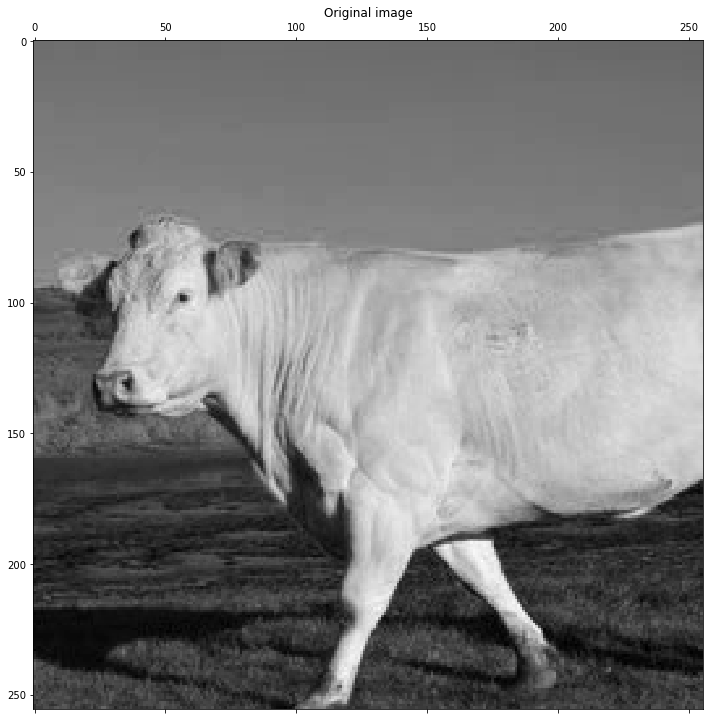

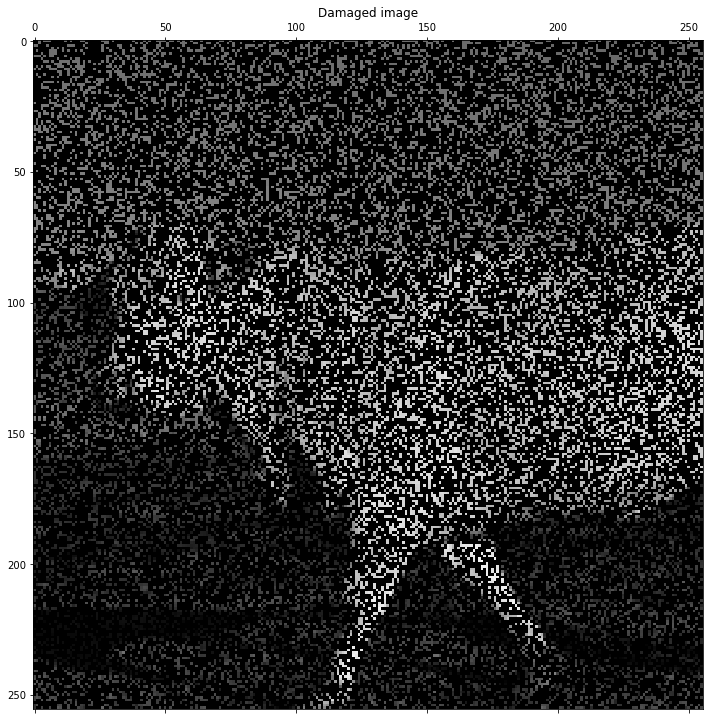

In [10]:
im=np.array(Image.open("./capu.jpg")).astype(float)[:,:,0]
np.random.seed(seed=1)
n1,n2=np.shape(im)
r=np.random.rand(n1,n2)
M=(r<0.3)
M = M*1.0
im_masq=im*M
wave="coif3"
lam=2
big_im_masq=upsize(im_masq)
big_M=upsize(M)
F,f,h,Df,proxh=operators_Inpainting(big_im_masq,big_M,lam,wave)
exit_crit=lambda x,y:npl.norm(x-y) #critère d'arrêt -> norme du gradient composite
sp=lambda x,y:np.dot(x.ravel(),y.ravel()) #produit scalaire utilisé -> produit scalaire entre les matrices "aplaties"
x0=big_im_masq
L=1
plt.rcParams["figure.figsize"] = (6,6)
plt.matshow(im,cmap="gray")
plt.title("Original image")
plt.matshow(im_masq,cmap="gray")
plt.title("Damaged image")

In [11]:
Niter=60000
epsilon=1e-6
rho=0.8
delta=0.99

In [12]:
tAR1=time.perf_counter()
xAR1=FISTA_automatic_restart(x0,1/L,Niter,epsilon,Df,proxh,F,exit_crit=exit_crit,out_cost=False)
tAR1=time.perf_counter()-tAR1
print("Automatic FISTA restart (exact value of L)")
print("Computation time:",tAR1)
print("Final cost:",F(xAR1))

Automatic FISTA restart (exact value of L)
Computation time: 12.099490844000684
Final cost: 2065089.9213746472


In [13]:
tBTR=time.perf_counter()
L0=1
rho=0.8
delta=0.99
xBTR=FISTA_BT_automatic_restart(x0, L0, rho, delta, Niter, epsilon, f, h, Df, proxh, exit_crit=exit_crit, sp=sp, out_cost=False, out_L=False, exit_norm=True)
tBTR=time.perf_counter()-tBTR
print("Automatic FISTA restart with backtracking")
print("Computation time:",tBTR)
print("Final cost:",F(xBTR))

Automatic FISTA restart with backtracking
Computation time: 9.162971482997818
Final cost: 2065089.9213746518


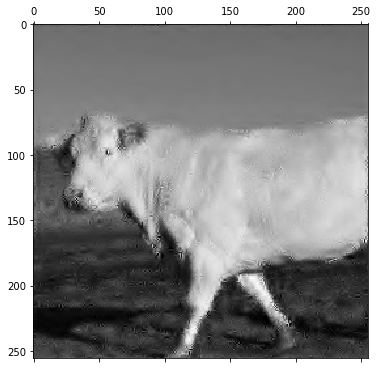

In [14]:
plt.rcParams["figure.figsize"] = (6,6)
plt.matshow(np.clip(xBTR[:n1,:n2],0,256),cmap="gray")

In [47]:
print(n1,n2)

256 256
